# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


Let's import the libraries we'll need.

In [1]:
import tensorflow as tf
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# Visualizations will be shown in the notebook.
%matplotlib inline
import matplotlib.image as mpimg
from itertools import groupby
import csv
from sklearn.model_selection import train_test_split
from scipy import ndimage as ndi
import cv2

---
## Step 0: Load The Data

We'll load our dataset from disk. Change `training_file` and `testing_file` values accordingly if the data isn't in those predefined paths.

In [2]:
# Load pickled data

training_file = "../traffic-signs-data/train.p"
testing_file = "../traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Below is a very brief data summary:

In [3]:
# Number of training examples
N_TRAIN = X_train.shape[0]
# Number of testing examples.
N_TEST = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
N_CLASSES = len(set(y_train))

# Prints a brief summary of the data
print('-----------------------------------------')
print("Number of training examples =", N_TRAIN)
print("Number of testing examples =", N_TEST)
print("Image data shape =", image_shape)
print("Number of classes =", N_CLASSES)
print('-----------------------------------------')

-----------------------------------------
Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
-----------------------------------------


Let's start exploring the dataset. The approaches we'll take in this step are:

* Plot a single random image of each class.
* Visualize through a bar chart the data distribution among classes (i.e. number of images per class).

***Plotting***

In [4]:
# Here we are defining some helper functions that we'll be using throughout this notebook.

def load_labels(csv_name):
    """
    Loads the labels into a dictionary from a given CSV file location.
    """
    d = {}
    with open(csv_name) as csvfile:
        reader = csv.DictReader(csvfile)
        d = {int(row['ClassId']): row['SignName'] for row in reader}
    return d

def show_sample_images(X, y):
    """
    Takes a data set, X, and its corresponding labels, y, and plots one image per class in a grid.
    """
    
    # Defines our grind and the spacing between cells.
    grid = gridspec.GridSpec(7, 7)
    grid.update(wspace=0.01, hspace=0.01)
    
    # Size of a single cell.
    plt.figure(figsize=(12,12))
    
    for i in range(N_CLASSES):
        # Select a cell to plot on
        ax1 = plt.subplot(grid[i])
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        
        # Consider only images of class i
        images_of_class = X[y == i]
        examples_per_class = len(images_of_class)
        
        # Get a random image of class i
        random_index = int(np.random.uniform() * examples_per_class)
        img = images_of_class[random_index]

        # Draw image.
        plt.subplot(7,7,i+1)
        plt.imshow(img)
        plt.axis('off')

Now that we have our helper function to visualize the actual images that comprise our data set, let's visualize the training set:

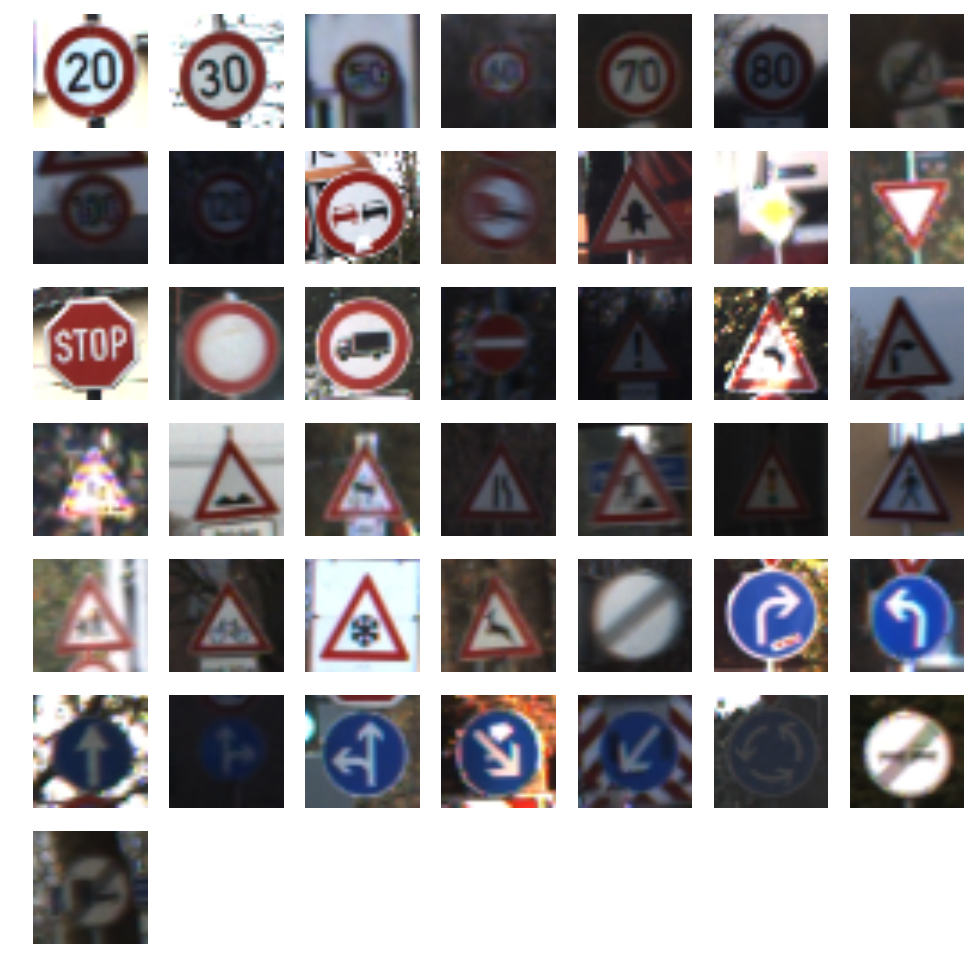

In [5]:
show_sample_images(X_train, y_train)

As we can see, there are some issues we can spot right away:

* Some images are blurred.
* Some images are too bright.
* Some images are too dark.
* Some images are out of focus.

These can cause a lot of trouble to our model. That's why we'll need to normalize our data before giving it to our neural network to process. More on this later!


We're not done exploring. Now let's look at the distribution of our images in the dataset (i.e. number of images per class). Let's start by defining a handy helper function:

In [6]:
def plot_bar_chart(dataset, title, color='cyan'):
    # Group the dataset.
    labels = load_labels('signnames.csv')
    data = {k: len(list(g)) for k, g in groupby(sorted(dataset[:]))}
    categories = range(len(data))
    
    # Make plot and put the proper labels.
    plt.figure(figsize=(6,16))
    plt.barh(categories, [data[k] for k in categories], color=color)
    
    plt.ylabel("Image class")
    plt.xlabel("Number of images")
    plt.title(title)
    
    plt.yticks(categories, [labels[k] + " (" + str(k) + ")" for k in categories]) 
    # Show plot
    plt.show()
    
    # Just to save some space
    del labels
    del data
    del categories

**Training** set exploration:

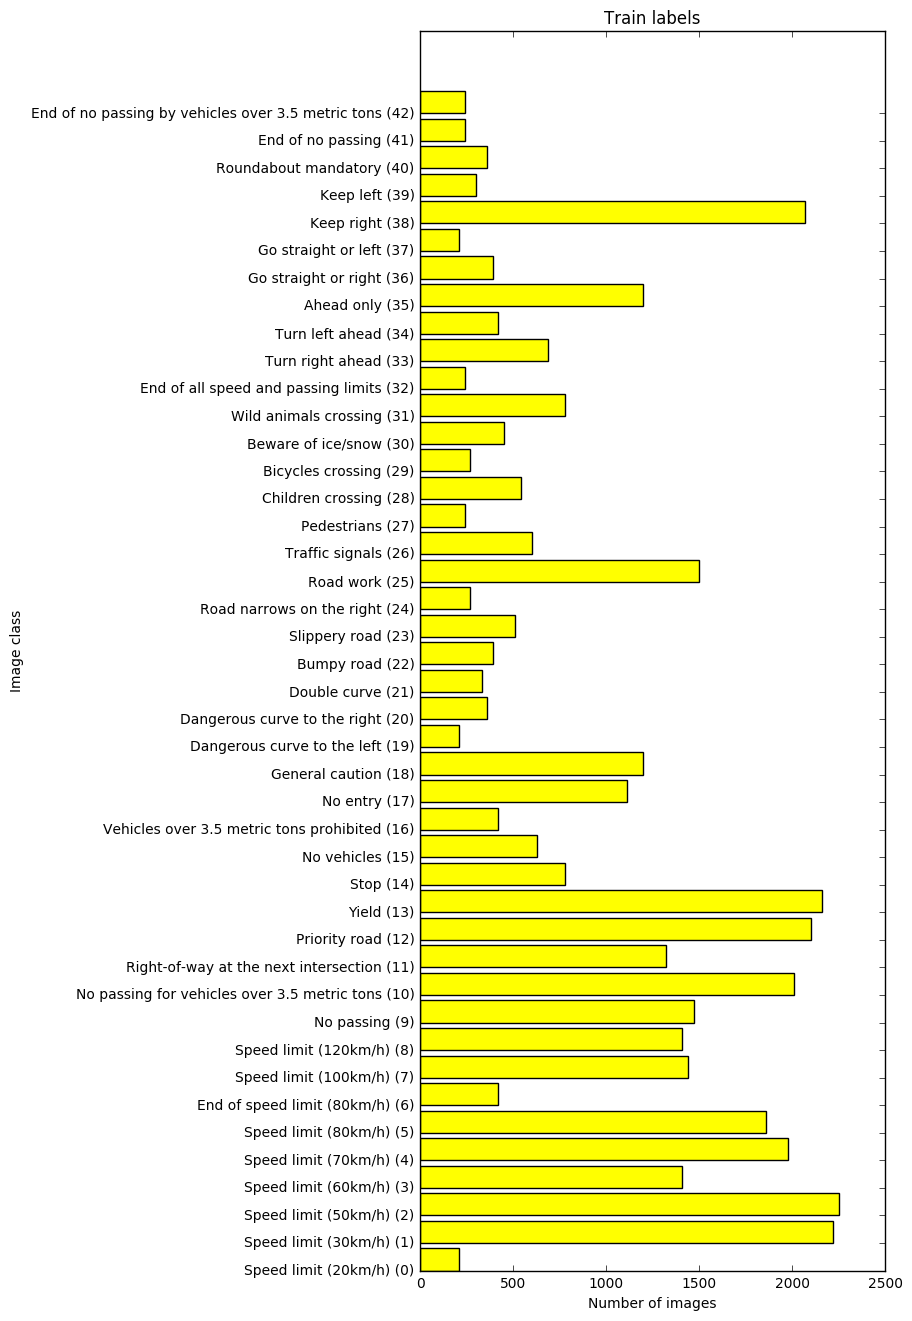

In [7]:
plot_bar_chart(y_train, "Train labels", color='yellow')

**Test** set exploration:

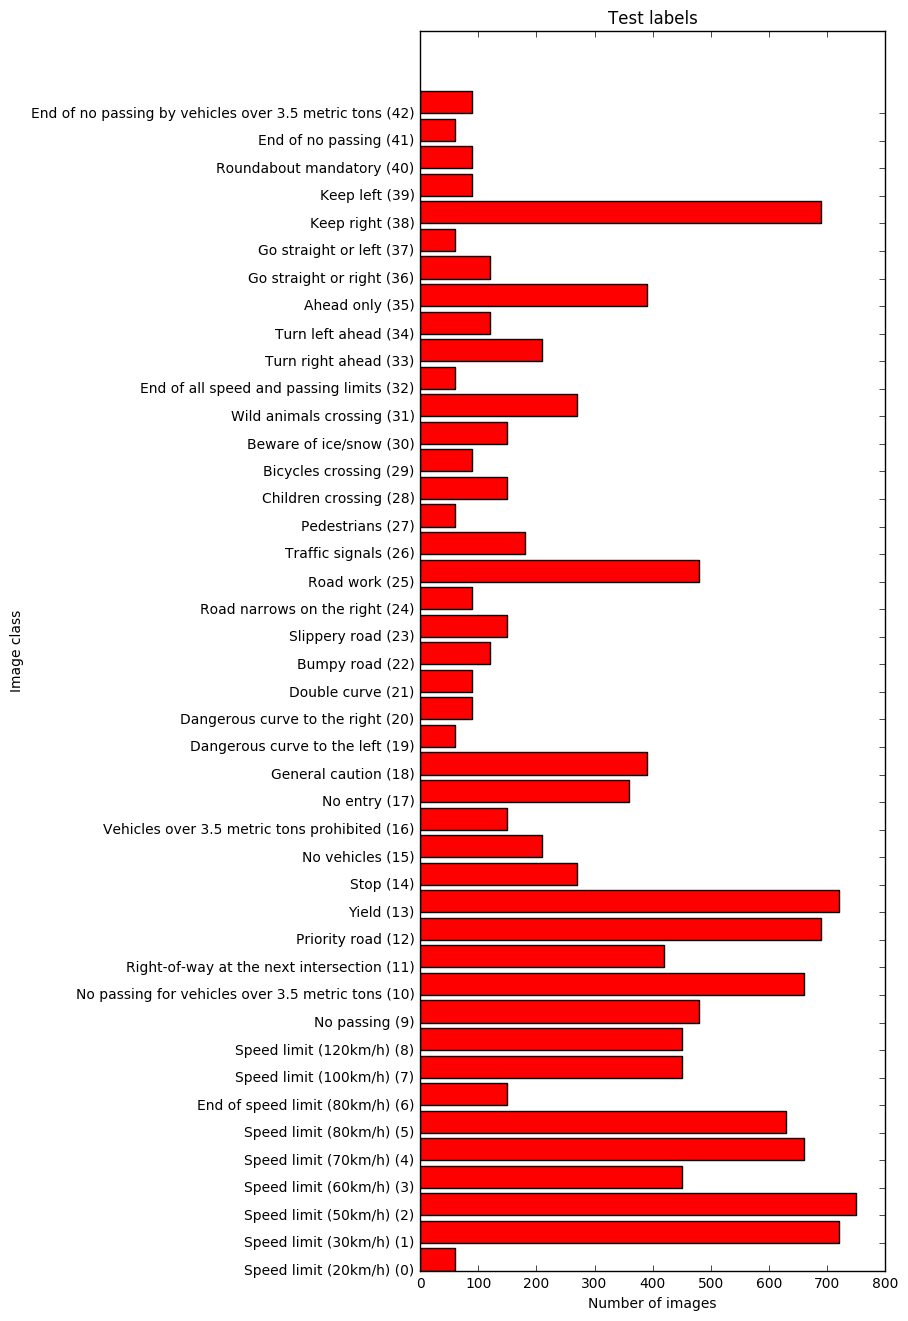

In [8]:
plot_bar_chart(y_test, "Test labels", color='red')

As we saw in the cells above, the data is not well distributed. There are classes that have less than 250 examples (0, 19), while others exceed 1000. This could be a problem because our model could not classify equally well all traffic signs.

In order to mitigate this, we'll generate some extra data by tweaking a bit each image of each class. (See pre-processing step)

---

## Step 2: Design and Test a Model Architecture

We'll use a Convolutional Neural Network to classify images in the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

Our selection of this kind of Neural Network relies on the fact that CNNs are specifically purposed to process images, by learning features in different patches of it, what allows us to share weights across the network and reduce the overall number of features needed to do the work, greatly improving the performance.

### Preprocessing

A very important step in every deep learning project is the preprocessing of the input data. In this particular case, given we're dealing with images in the RGB space, our values per channel will range between 0 and 255. This could lead to numeric overflow problems that may harm deeply our model. Another reason to normalize data is to enhance the images in order to achieve a better performance/accuracy.

Below we're defining some preprocessing helper functions:

In [9]:
def histogram_equalization(data):
    """
    Converts each image in RGB space to YUV space and normalize its Y channel and then turns the image back to RGB space..
    """
    for i in range(len(data)):
        # Convert to YUV-space which has intensity as one of its components
        img_yuv = cv2.cvtColor(data[i], cv2.COLOR_BGR2YUV)
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
        data[i] = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
        
    return data


def zero_centered_normalization(data):
    data = data.astype(float)
    data -= np.mean(data, axis=0)  # zero center
    data /= np.std(data, axis=0)  # normalize
    
    return data

Let's use these functions and take a look at the effect they have on the images.

Let's start with **zero_centered_normalization**

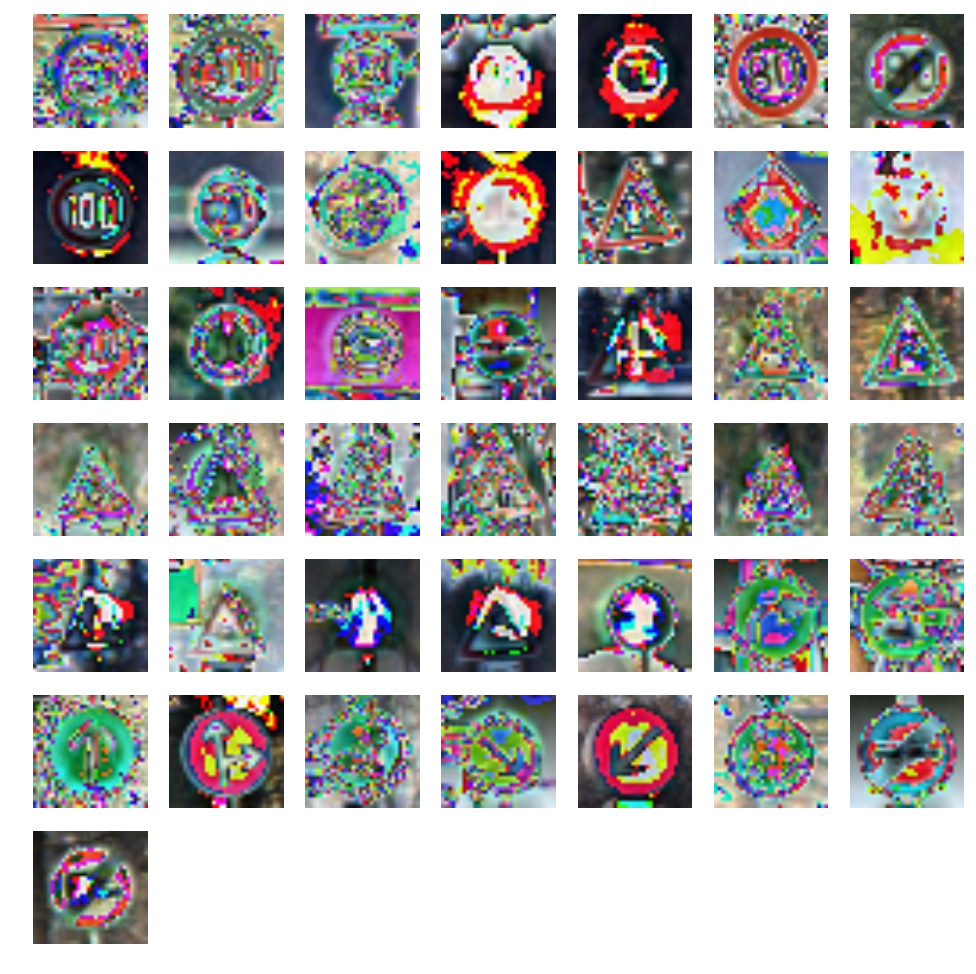

In [10]:
X_train_copy = X_train.copy()
X_train_copy = zero_centered_normalization(X_train_copy)

show_sample_images(X_train_copy, y_train)
del X_train_copy

Now, it's **histogram_equalization** turn:

In [11]:
X_train_copy = X_train.copy()
X_train_copy = histogram_equalization(X_train_copy)

show_sample_images(X_train_copy, y_train)
del X_train_copy

Finally, let's apply both of them:

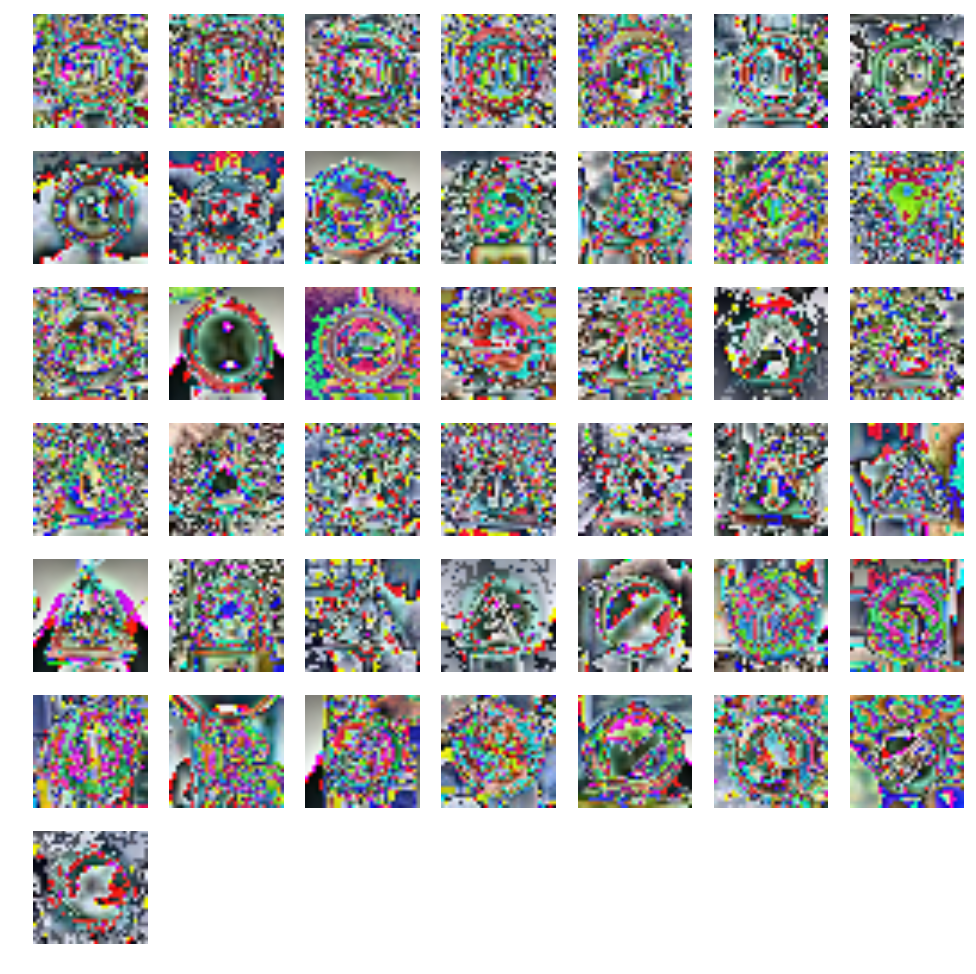

In [12]:
X_train_copy = X_train.copy()
X_train_copy = zero_centered_normalization(histogram_equalization(X_train_copy))

show_sample_images(X_train_copy, y_train)
del X_train_copy

We'll use both **histogram equalization** and **zero centered normalization**, so we reduce the spikes in contrast between images and, at the same, we can keep our gradients from exploding due to overflow or numeric errors.

### Data augmentation

As we stated a few cells above, our dat may be insufficient for some types of signs. So, we'll augment our data set by applying a series of transformations:
 - Horizontal flipping.
 - 10° rotation..
 - -10° rotation.
 - 5° rotation.
 - -5° rotation.
 
We're expanding 5 times the size of our training data. You may think that we'll harm our model by doing this rotation, but one of the advantages of CNNs is that they're invariant to small perturbations ;)

Below we're defining the helper function in charge of performing the aforementioned transformations:

In [13]:
def rotate(img, degrees=180):
    return ndi.rotate(img, degrees, reshape=False)

### Model 

We'll use a Convolutional Neural Network. In particular, we'll use a LeNet because it acts as a very solid starting point. Given our CNN will catch relatively simple aspects of the images in the first layers, we'll start with a depth of 32. As we approach the outer layers, we want to make our model deeper in order to learn more complex shapes and patterns. That's why our second convolutional layer has a depth of 64. Our last two layers do not convolve. They are in charge of the actual classification task, based on the output of the convolution layers. For that matter we use a first fully connected layer of 128 nodes, followed by a second fully connected layer of 43 nodes, one for each class. Between convolutions we're using max pooling so we down-sample the images and prevent overfitting (basically, we don't want to take into account every little noise and minuscule detail):

In [14]:
from tensorflow.contrib.layers import flatten

# Hyperparameters for random initialization
mu = 0
sigma = 0.1

def weight_variable(shape):
    return tf.Variable(tf.truncated_normal(shape, mean=mu, stddev=sigma))

def bias_variable(shape):
    return tf.Variable(tf.zeros(shape))

# LeNet architecture:
# INPUT -> CONV -> ACT -> POOL -> CONV -> ACT -> POOL -> FLATTEN -> FC -> ACT -> FC
def LeNet(x, keep_prob=None):
    # Reshape from 2D to 4D. This prepares the data for
    # convolutional and pooling layers.
    x = tf.reshape(x, (-1, 32, 32, 3))
    
    # Convolution layer 1.
    cv1_filter_width = 5
    cv1_filter_height = 5
    cv1_output_depth = 32
    cv1_weight = weight_variable([cv1_filter_width, cv1_filter_height, 3, cv1_output_depth])
    cv1_bias = bias_variable(cv1_output_depth)
    cv1_layer = tf.nn.conv2d(x, cv1_weight, strides=[1,1,1,1], padding='VALID')
    cv1_layer = tf.nn.bias_add(cv1_layer, cv1_bias)
    cv1_layer = tf.nn.relu(cv1_layer)
    
    # Pooling layer 1.
    p1_filter_width = 2
    p1_filter_height = 2
    p1_output_depth = 32
    p1_layer = tf.nn.max_pool(cv1_layer, ksize=[1, p1_filter_width, p1_filter_height, 1], strides=[1,1,1,1], padding='VALID')
        
    # Convolution layer 2.
    cv2_filter_width = 5
    cv2_filter_height = 5
    cv2_output_depth = 64
    cv2_weight = weight_variable([cv2_filter_width, cv2_filter_height, p1_output_depth, cv2_output_depth])
    cv2_bias = bias_variable(cv2_output_depth)
    cv2_layer = tf.nn.conv2d(p1_layer, cv2_weight, strides=[1,1,1,1], padding='VALID')
    cv2_layer = tf.nn.bias_add(cv2_layer, cv2_bias)
    cv2_layer = tf.nn.relu(cv2_layer)

    # Pooling layer 2.
    p2_filter_width = 2
    p2_filter_height = 2
    p2_layer = tf.nn.max_pool(cv2_layer, ksize=[1, p2_filter_width, p2_filter_height, 1], strides=[1,1,1,1], padding='VALID')
    
    # Flatten layer
    flatten_layer = flatten(p2_layer)

    # Fully connected layer 1
    fc1_outputs = 128
    fc1_weigth = weight_variable([flatten_layer.get_shape().as_list()[-1], fc1_outputs])
    fc1_biases = bias_variable([fc1_outputs])
    fc1_layer = tf.add(tf.matmul(flatten_layer, fc1_weigth), fc1_biases)
    fc1_layer = tf.nn.relu(fc1_layer)
    
    # Dropout
    if keep_prob is not None:
        fc1_layer = tf.nn.dropout(fc1_layer, keep_prob)
    
    # Fully connected layer 2
    fc2_outputs = N_CLASSES
    fc2_weight = weight_variable([fc1_outputs, fc2_outputs])
    fc2_biases = bias_variable([fc2_outputs])
    fc2_layer = tf.add(tf.matmul(fc1_layer, fc2_weight), fc2_biases)

    # Return the result of the last fully connected layer.
    return fc2_layer

Before starting training our model, we'll normalize our data with the **histogram_equalization** and **zero_centered_normalization** functions defined above. We'll do this one time!

In [15]:
X_train = zero_centered_normalization(histogram_equalization(X_train))

Our **test set** is **SACRED**, we should only use it to test our final model. For this reason we need a validaton set. We'll take 20% of our training set and use it to validate the performance of our model after each epoch.

Regarding the **data augmentation**, we will augment the whole dataset using the **augment_data** function.

In [16]:
def augment_data(X, y, factor=5, rotations=None):
    """
    Given training data, X, with their respective labels, y, and a factor of augmentaton, we'll expand X and y factor times
    applying the supplied rotations or using default ones: [180, 10, -10, 5, -5, -15, 15]
    """
    
    if not rotations:
        rotations = [180, 10, -10, 5, -5, -15, 15]
    
    X_augmented = []
    y_augmented = []
    
    n_examples = len(X)
    
    for i in range(n_examples):
        X_augmented.append(X[i])
        y_augmented.append(y[i])
        
        for r in rotations[:factor]:
            X_augmented.append(rotate(X[i], r))
            y_augmented.append(y[i])
    
    return np.array(X_augmented), np.array(y_augmented)

X_train, y_train = augment_data(X_train, y_train)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Some statistics:
print("TRAINING set length:", len(X_train))
print("VALIDATION set length:", len(X_valid))

TRAINING set length: 188203
VALIDATION set length: 47051


Our hyperparams will be:

In [17]:
BATCH_SIZE = 256
EPOCHS = 15
N_INPUT = 32 * 32 * 3
LEARNING_RATE = 0.001

Our model:

In [18]:
X = tf.placeholder(tf.float32, shape=[None, N_INPUT])
y = tf.placeholder(tf.float32, shape=[None, N_CLASSES])
keep_prob = tf.placeholder(tf.float32)
logits = LeNet(X, keep_prob)

### Training

To train our model we'll use the following optimizers:

In [19]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

First, let's adapt the data:

In [20]:
def reshape_input(data):
    """
    Flattens the input.
    """
    return data.reshape((-1, N_INPUT))

def onehot_encode(data):
    """
    Onehot encodes the data.
    """
    return tf.Session().run(tf.one_hot(data, N_CLASSES))

# Flatten the inputs.
X_train_flat = reshape_input(X_train)
X_valid_flat = reshape_input(X_valid)

# One hot encode the labels.
y_train_onehot = onehot_encode(y_train)
y_valid_onehot = onehot_encode(y_valid)

We'll use a saver to store the best model we find in our training:

In [21]:
save_location = "trained_model.ckpt"
saver = tf.train.Saver()

In [22]:
from timeit import default_timer as timer

def eval_dataset(data, labels):
    n_examples = data.shape[0]
    total_batches = n_examples // BATCH_SIZE
    
    total_accuracy = 0 
    total_loss = 0
    
    for i in range(total_batches):
        offset = (i * BATCH_SIZE)
        batch_x = data[offset:offset + BATCH_SIZE, :]
        batch_y = labels[offset:offset + BATCH_SIZE, :]
        l, acc = session.run([loss, accuracy], feed_dict={X: batch_x, y: batch_y, keep_prob: 1.0})
        
        total_accuracy += (acc * batch_x.shape[0])
        total_loss += (l * batch_x.shape[0])
    
    return total_loss / n_examples, total_accuracy / n_examples


def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0]) 
    shuffled_dataset = dataset[permutation]
    shuffled_labels = labels[permutation]
 
    return shuffled_dataset, shuffled_labels


init = tf.global_variables_initializer()

with tf.Session() as session:
    session.run(init)  # Initialize variables
    
    # Accumulators used to plot.
    loss_acc = []
    train_acc = []
    valid_acc = []
    
    # Keeps track of the best accuracy.
    best_acc_so_far = 0
    
    meaningfulness_threshold = 30 / len(X_valid)  # Rule of 30
    
    global_start = timer()
    for epoch in range(EPOCHS):
        epoch_start = timer()
        total_batches = X_train.shape[0] // BATCH_SIZE
        
        print("Starting epoch", epoch)
        print("Working...")
        
        # In order to prevent learning some kind of underlaying ordering of the data, let's shuffle it
        # at the beginning of each epoch.
        X_train, y_train = randomize(X_train, y_train)
        
        for i in range(total_batches):
            offset = (i * BATCH_SIZE)
            batch_x = X_train_flat[offset:offset + BATCH_SIZE, :]
            batch_y = y_train_onehot[offset:offset + BATCH_SIZE, :]
            
            session.run(optimizer, feed_dict={X: batch_x, y: batch_y, keep_prob: 0.5})
        
        training_loss, training_accuracy = eval_dataset(X_train_flat, y_train_onehot)
        loss_acc.append(training_loss)
        train_acc.append(training_accuracy)
        
        validation_loss, validation_accuracy = eval_dataset(X_valid_flat, y_valid_onehot)
        valid_acc.append(validation_accuracy)
        
        
        if validation_accuracy - best_acc_so_far >= meaningfulness_threshold:
            print("IMPROVEMENT:", 100 * (validation_accuracy - best_acc_so_far))
            best_acc_so_far = validation_accuracy
            saver.save(session, save_location)
            epochs_without_improvement = 0
            
        epoch_end = timer()
        
        print("EPOCH", epoch, "SUMMARY: ")
        print("\tLoss:", training_loss)
        print("\tTraining accuracy:", training_accuracy * 100)
        print("\tValidation accuracy:", validation_accuracy * 100)
        print("\tThis epoch took: ", (epoch_end - epoch_start) / 60, "minutes")
        print("\tCurrent BEST accuracy:", best_acc_so_far * 100 )
        print("------------------------------------------\n")

Starting epoch 0
Working...
IMPROVEMENT: 65.5671505388
EPOCH 0 SUMMARY: 
	Loss: 1.08014294163
	Training accuracy: 66.2167978194
	Validation accuracy: 65.5671505388
	This epoch took:  1.9991253874500217 minutes
	Current BEST accuracy: 65.5671505388
------------------------------------------

Starting epoch 1
Working...
IMPROVEMENT: 29.4829015324
EPOCH 1 SUMMARY: 
	Loss: 0.147728582376
	Training accuracy: 96.0053771725
	Validation accuracy: 95.0500520712
	This epoch took:  6.391740731833306 minutes
	Current BEST accuracy: 95.0500520712
------------------------------------------

Starting epoch 2
Working...
IMPROVEMENT: 2.46753522773
EPOCH 2 SUMMARY: 
	Loss: 0.050781463278
	Training accuracy: 98.4947104988
	Validation accuracy: 97.5175872989
	This epoch took:  3.1331222184166716 minutes
	Current BEST accuracy: 97.5175872989
------------------------------------------

Starting epoch 3
Working...
IMPROVEMENT: 0.835263862617
EPOCH 3 SUMMARY: 
	Loss: 0.0234645730445
	Training accuracy: 99.292

Let's see how our model does on the training set:

Restoring best model from disk...
Test accuracy (ORIGINAL): 63.6500395883
Test accuracy (HISTOGRAM EQUALIZED): 58.7648456057
Test accuracy (ZERO CENTERED NORMALIZED): 95.7957244656
Test accuracy (HE + ZCN): 95.8749010293
GLOBAL RUN TIME: 38.47265907574999 minutes


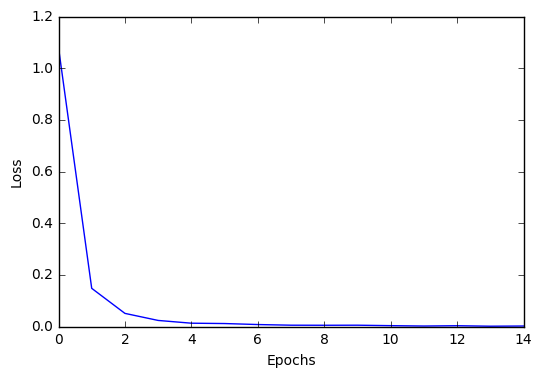

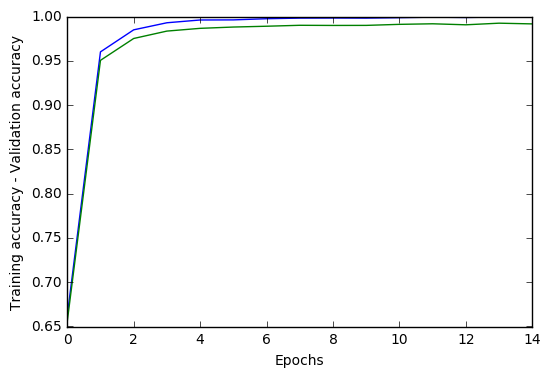

In [23]:

with tf.Session() as session:
    print("Restoring best model from disk...")
    saver.restore(session,"./" + save_location)
    
    X_test_flat = reshape_input(X_test)
    y_test_onehot = onehot_encode(y_test)
    
    test_loss, test_accuracy = eval_dataset(X_test_flat, y_test_onehot) 
    print("Test accuracy (ORIGINAL):", test_accuracy * 100)
    global_end = timer()
    
    X_test_flat = reshape_input(histogram_equalization(X_test))
    test_loss, test_accuracy = eval_dataset(X_test_flat, y_test_onehot) 
    print("Test accuracy (HISTOGRAM EQUALIZED):", test_accuracy * 100)
    
    X_test_flat = reshape_input(zero_centered_normalization(X_test))
    test_loss, test_accuracy = eval_dataset(X_test_flat, y_test_onehot) 
    print("Test accuracy (ZERO CENTERED NORMALIZED):", test_accuracy * 100)
    
    X_test_flat = reshape_input(zero_centered_normalization(histogram_equalization(X_test)))
    test_loss, test_accuracy = eval_dataset(X_test_flat, y_test_onehot) 
    print("Test accuracy (HE + ZCN):", test_accuracy * 100)
    
    print("GLOBAL RUN TIME:", (global_end - global_start) / 60, "minutes")

epochs_range = range(EPOCHS)
plt.plot(epochs_range, loss_acc)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.plot(epochs_range, train_acc)
plt.plot(epochs_range, valid_acc)
plt.xlabel("Epochs")
plt.ylabel("Training accuracy - Validation accuracy")
plt.show()

To train our model we used an **Adam Optimizer**. This kind of optimizer is better than Gradient Descent because it usually converges faster by keeping track of the momentum. It adjusts the learning rate so our model doesn't overshoot trying to find the right direction downwards.

We used 0.001 as **learning rate** because we prefer slow, steady progress than reckless, uncontrolled learning. This is why we need to use a little bit more epochs. We set **epochs=15** as a result of trial and error and a bit of analysis of the graphs above: After 8 epochs the model improves very little, so we use 15 in order to give it time to squeeze a bit more accuracy from the data (After 10 epochs there's a very tiny improvement).

In order to prevent overfitting, we used **dropout** during training, although only between the fully connected layers. We didn't use dropout after the convolutional layers because it really slows down the learning process and does not seem to improve the performance.

With these parameters, we can achieve 95.87% accuracy on the test set (preprocessed in the same way as the training set).

---
The process that produced the model described above was, in the most part, trial and error. Different approaches were taken: dropout after each layer, deeper networks (3 convolutions and 3 fully connected layers), wider layers, more epochs, batch augmentation instead of whole dataset augmentation, bigger learning rate, gradient descent optimizer, more jittering during the augmentation phase (translations, affine transformations, cropping, etc). Nonetheless, nothing proved better than what was presented above. 

It is necessary to remark that this trial and error approach consumes a lot of time. Each trial took about 4 hours to give results. There're numerous different settings that surely performs better than this, but more time and computational resources would be needed to find them. 

Lastly, some preprocessing ideas (such as histogram equalization and YUV<->RGB transform) were borrowed from [here](http://people.idsia.ch/~juergen/nn2012traffic.pdf) and [here](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf)


---

## Step 3: Test Model on New Images

Let's now test our trained model on some real images and see how it performs. We'll use this helper functions:

In [177]:
def resize(img, new_width=32, new_height=32):
    return cv2.resize(img,(new_width, new_height), interpolation = cv2.INTER_CUBIC)

def preprocess(img):
    return reshape_input(resize(img))

We prepared a bunch of images for this test. Let's see them in their original size and then resized:

**overtaking.jpg**:

In [152]:
# Original:
img = mpimg.imread('overtaking.jpg')
plt.imshow(img)
print("Dimensions:", img.shape[:-1])

Dimensions: (1300, 1300)


Dimensions: (32, 32)


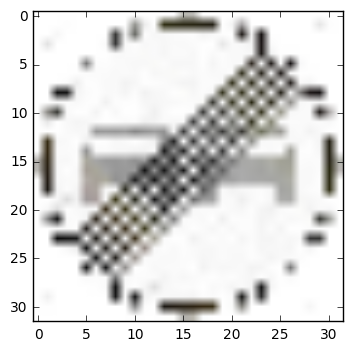

In [150]:
# Resized:
img = resize(mpimg.imread('overtaking.jpg'))
plt.imshow(img)
print("Dimensions:", img.shape[:-1])

*Possible issues*:
- Loss of detail due to downsizing.
- Too much contrast.

**pare.jpg**:

Dimensions: (194, 259)


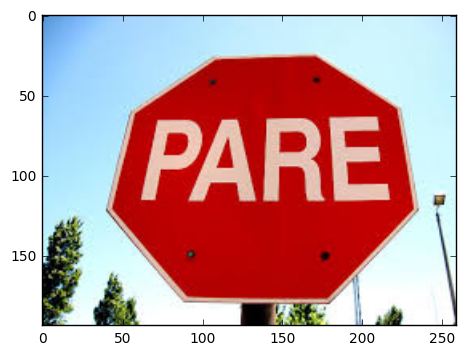

In [153]:
# Original:
img = mpimg.imread('pare.jpg')
plt.imshow(img)
print("Dimensions:", img.shape[:-1])

Dimensions: (32, 32)


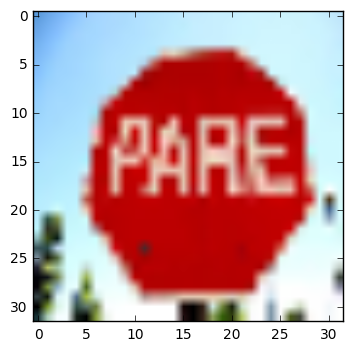

In [154]:
# Resized:
img = resize(mpimg.imread('pare.jpg'))
plt.imshow(img)
print("Dimensions:", img.shape[:-1])

*Possible issues*:
- Sign in spanish.
- "Bottom-up" perspective.

**stop.jpg**:

Dimensions: (233, 216)


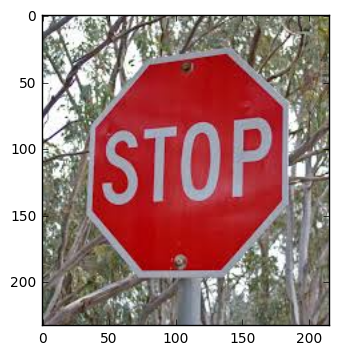

In [157]:
# Original:
img = mpimg.imread('stop.jpg')
plt.imshow(img)
print("Dimensions:", img.shape[:-1])

Dimensions: (32, 32)


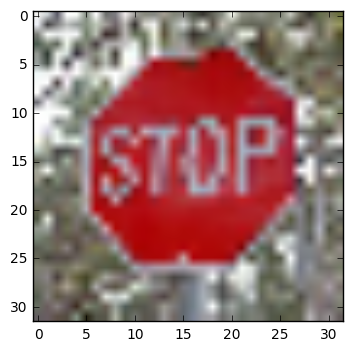

In [167]:
# Resized:
img = resize(mpimg.imread('stop.jpg'))
plt.imshow(img)
print("Dimensions:", img.shape[:-1])

*Possible issues*:
- Loss of detail due to downsizing.
- Bushes behind the sign.

**20.jpg**:

Dimensions: (224, 225)


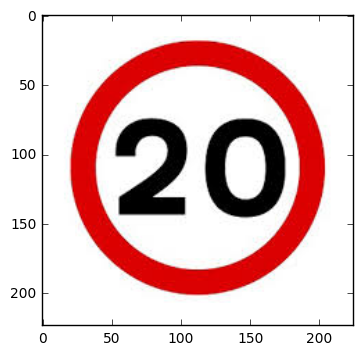

In [159]:
# Original:
img = mpimg.imread('20.jpg')
plt.imshow(img)
print("Dimensions:", img.shape[:-1])

Dimensions: (32, 32)


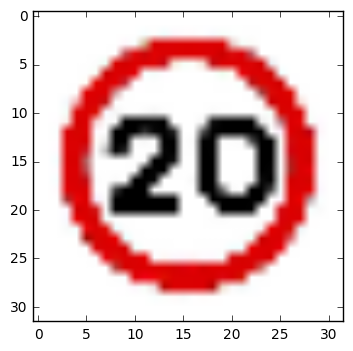

In [160]:
# Resized:
img = resize(mpimg.imread('20.jpg'))
plt.imshow(img)
print("Dimensions:", img.shape[:-1])

*Possible issues*:
- Too much contrast.
- Similarities between 7 and 2.

**100.jpg**:

In [161]:
# Original:
img = mpimg.imread('100.jpg')
plt.imshow(img)
print("Dimensions:", img.shape[:-1])

Dimensions: (179, 282)


*Possible issues*:
- Too much contrast.
- Similarities between 10 and 100.

Dimensions: (32, 32)


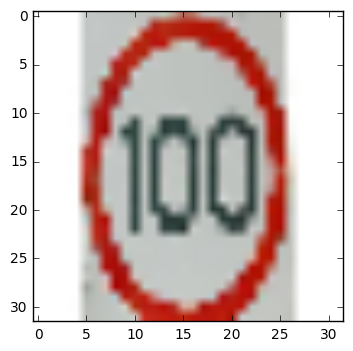

In [162]:
# Resized:
img = resize(mpimg.imread('100.jpg'))
plt.imshow(img)
print("Dimensions:", img.shape[:-1])

**no-entry.jpg**:

Dimensions: (319, 306)


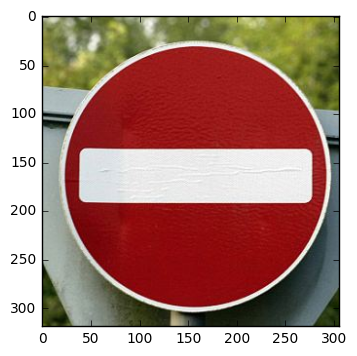

In [163]:
# Original:
img = mpimg.imread('no-entry.jpg')
plt.imshow(img)
print("Dimensions:", img.shape[:-1])

Dimensions: (32, 32)


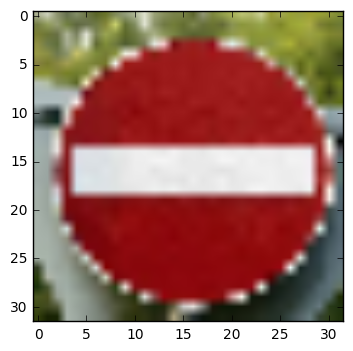

In [164]:
# Resized:
img = resize(mpimg.imread('no-entry.jpg'))
plt.imshow(img)
print("Dimensions:", img.shape[:-1])

*Possible issues*:
- Bushes behind the sign.

**right.jpg**:

In [166]:
# Original:
img = mpimg.imread('right.jpg')
plt.imshow(img)
print("Dimensions:", img.shape[:-1])

Dimensions: (225, 225)


In [165]:
# Resized:
img = resize(mpimg.imread('right.jpg'))
plt.imshow(img)
print("Dimensions:", img.shape[:-1])

Dimensions: (32, 32)


*Possible issues*:
- Squared shape instead of round shape.
- Yellow background instead of blue.
- Black, squared arrow instead of white, rounded arrow.

#### Evaluation

In order to evaluate our model agains each image, we'll:
- Load our previously trained model from disk.
- Calculate the softmax probabilities for each class.
- Look at the top 5 probabilities and their corresponding classes.
- Print the accuracy of our model.

In [188]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

test_examples = [
    {"image": "overtaking.jpg", "expected_class": 41},
    {"image": "stop.jpg", "expected_class": 14},
    {"image": "pare.jpg", "expected_class": 14},
    {"image": "right.jpg", "expected_class": 33},
    {"image": "100.jpg", "expected_class":7}, 
    {"image": "20.jpg", "expected_class": 0},
    {"image": "no-entry.jpg", "expected_class": 17}]

well_classified = 0
total_examples = len(test_examples)
for example in test_examples:
    img = mpimg.imread(example["image"])
    
    with tf.Session() as session:
        print("Restoring best model from disk...")
        print("Processing image", example["image"])
        saver.restore(session,"./" + save_location)
        
        top_k = session.run(tf.nn.top_k(tf.nn.softmax(logits),k=5), feed_dict={X:preprocess(img), keep_prob:1.0})
        got = top_k.indices[0][0]
        print("Expected:", example["expected_class"])
        print("Got:", got)
        
        if got == example["expected_class"]:
            well_classified += 1
        
        print("Softmax (TOP-5):", list(zip(top_k.values[0], top_k.indices[0])))
        print("----------------------------------\n")

print("MODEL ACCURACY: ", well_classified / total_examples * 100)

Restoring best model from disk...
Processing image overtaking.jpg
Expected: 41
Got: 30
Softmax (TOP-5): [(0.99367976, 30), (0.0063201706, 11), (1.5834052e-18, 23), (2.4145941e-21, 26), (4.7257226e-22, 24)]
----------------------------------

Restoring best model from disk...
Processing image stop.jpg
Expected: 14
Got: 14
Softmax (TOP-5): [(1.0, 14), (0.0, 0), (0.0, 1), (0.0, 2), (0.0, 3)]
----------------------------------

Restoring best model from disk...
Processing image pare.jpg
Expected: 14
Got: 14
Softmax (TOP-5): [(1.0, 14), (0.0, 0), (0.0, 1), (0.0, 2), (0.0, 3)]
----------------------------------

Restoring best model from disk...
Processing image right.jpg
Expected: 33
Got: 14
Softmax (TOP-5): [(1.0, 14), (0.0, 0), (0.0, 1), (0.0, 2), (0.0, 3)]
----------------------------------

Restoring best model from disk...
Processing image 100.jpg
Expected: 7
Got: 7
Softmax (TOP-5): [(1.0, 7), (0.0, 0), (0.0, 1), (0.0, 2), (0.0, 3)]
----------------------------------

Restoring best mo

From the previous tests we can conclude that even when our model did a decent job in the test set, it is far from being prepared to classify traffic signs in a real world setting. This may be a consequence of a limited training set (this is: our training set isn't diverse enough), a bias towards the German traffic signs (although it predicted correctly the "PARE" ("Stop" in Spanish) sign), an insufficiently trained model, among other causes.

---
